In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [2]:
# Load the dataset
appl_train = pd.read_csv('home-credit-default-risk/application_train.csv')

# 1. Problem Research

Home Credit Indonesia is a finance company that provides financing services for customers who shop either online or offline. They provide financing services for customers who want to buy various products such as household utilities, electronics, handphones, furniture, etc.

As a financing service company, the main problem that Home Credit Indonesia must solve is **how to provide installments to customers with a high probability of successful loan payment**.

## 1.1 Goal
**Achieve higher rate of customer's success installment payment.**

## 1.2 Objective
**Build a better model to predict wether the customer will have successful loan payment or not.**

## 1.3 Metrics
**Use F1 Score and ROC AUC to choose the best model to use.**

# 2. Data Pre-Processing

## 2.1 NA Values and Label Encoding 

We will drop any feature with more than 30% NA value.

In [3]:
# Define the max number of allowed NA values and count the NA values (in this case 30%)
na_limit = int(0.3 * appl_train.shape[0])
na_count = appl_train.isna().sum()

# Drop column if it has NA values more than the threshold
col_to_drop_by_na_count = na_count.where(na_count>=na_limit).dropna().index
appl_train_dropped = appl_train.drop(col_to_drop_by_na_count, axis=1)

# Drop additional columns
appl_train_dropped = appl_train_dropped.drop([f"FLAG_DOCUMENT_{x}" for x in range(2, 22)], axis=1)
appl_train_dropped.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


The first feature dropping gives us 52 features left to work with. The next step is to encode the categorical features

In [4]:
# Encode the categorical columns
encoder_dict = {} # Dictionary to store the feature encoders

categorical_features = appl_train_dropped.select_dtypes('object')
for x in categorical_features:
    encoder_dict[x] = LabelEncoder()
    appl_train_dropped[x] = encoder_dict[x].fit_transform(appl_train_dropped[x])
appl_train_dropped.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, fill the NA values with the most appropriate values and observe the distribution.

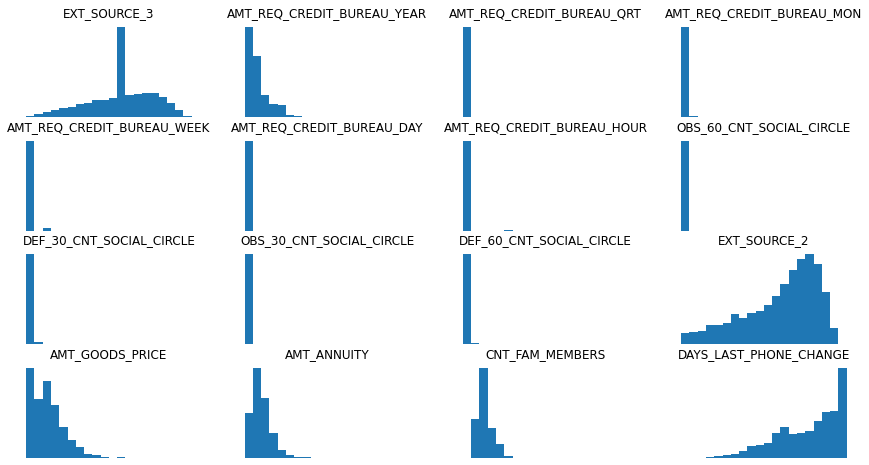

In [5]:
# Define columns with NA to fill
col_with_na = appl_train_dropped.isna().sum().sort_values(ascending=False).head(16).index

# Test to fill NA values 
fill_na_dummy = appl_train_dropped.fillna({
    'AMT_ANNUITY': appl_train_dropped['AMT_ANNUITY'].mean(),
    'AMT_GOODS_PRICE': appl_train_dropped['AMT_GOODS_PRICE'].mean(),
    'CNT_FAM_MEMBERS': 0,
    'EXT_SOURCE_2': appl_train_dropped['EXT_SOURCE_2'].mean(),
    'EXT_SOURCE_3': appl_train_dropped['EXT_SOURCE_3'].mean(),
    'OBS_30_CNT_SOCIAL_CIRCLE': 0,
    'DEF_30_CNT_SOCIAL_CIRCLE': 0,
    'OBS_60_CNT_SOCIAL_CIRCLE': 0,
    'DEF_60_CNT_SOCIAL_CIRCLE': 0,
    'DAYS_LAST_PHONE_CHANGE': appl_train_dropped['DAYS_LAST_PHONE_CHANGE'].mean(),
    'AMT_REQ_CREDIT_BUREAU_HOUR': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_HOUR'].mean(),
    'AMT_REQ_CREDIT_BUREAU_DAY': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_DAY'].mean(),
    'AMT_REQ_CREDIT_BUREAU_WEEK': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_WEEK'].mean(),
    'AMT_REQ_CREDIT_BUREAU_MON': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_MON'].mean(),
    'AMT_REQ_CREDIT_BUREAU_QRT': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_QRT'].mean(),
    'AMT_REQ_CREDIT_BUREAU_YEAR': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_YEAR'].mean(),
})

# Check the distribution
fig, ax = plt.subplots(4, 4, figsize=(15,8))
i = 0
for x in range(4):
    for y in range(4):
        ax[x][y].hist(fill_na_dummy[col_with_na[i]], bins=20)
        ax[x][y].set_title(col_with_na[i])
        ax[x][y].axis('off')
        i += 1

We can see that there are strange distribution in EXT_SOURCE_3 feature after we fill the NA values. So we'll fix the NA replacement value for the EXT_SOURCE_3 feature using random select from exsisting value rather than using the mean value.

<AxesSubplot:ylabel='Frequency'>

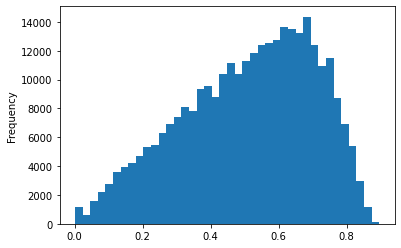

In [6]:
# Fill NA values 
appl_train_dropped = appl_train_dropped.fillna({
    'AMT_ANNUITY': appl_train_dropped['AMT_ANNUITY'].mean(),
    'AMT_GOODS_PRICE': appl_train_dropped['AMT_GOODS_PRICE'].mean(),
    'CNT_FAM_MEMBERS': 0,
    'EXT_SOURCE_2': appl_train_dropped['EXT_SOURCE_2'].mean(),
    'OBS_30_CNT_SOCIAL_CIRCLE': 0,
    'DEF_30_CNT_SOCIAL_CIRCLE': 0,
    'OBS_60_CNT_SOCIAL_CIRCLE': 0,
    'DEF_60_CNT_SOCIAL_CIRCLE': 0,
    'DAYS_LAST_PHONE_CHANGE': appl_train_dropped['DAYS_LAST_PHONE_CHANGE'].mean(),
    'AMT_REQ_CREDIT_BUREAU_HOUR': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_HOUR'].mean(),
    'AMT_REQ_CREDIT_BUREAU_DAY': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_DAY'].mean(),
    'AMT_REQ_CREDIT_BUREAU_WEEK': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_WEEK'].mean(),
    'AMT_REQ_CREDIT_BUREAU_MON': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_MON'].mean(),
    'AMT_REQ_CREDIT_BUREAU_QRT': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_QRT'].mean(),
    'AMT_REQ_CREDIT_BUREAU_YEAR': appl_train_dropped['AMT_REQ_CREDIT_BUREAU_YEAR'].mean(),
})

ext_source_3_values = appl_train_dropped['EXT_SOURCE_3'].dropna().values
appl_train_dropped['EXT_SOURCE_3'] = appl_train_dropped['EXT_SOURCE_3'].apply(lambda x: x if str(x)!="nan" else np.random.choice(ext_source_3_values))
appl_train_dropped['EXT_SOURCE_3'].plot.hist(bins=40)

## 2.2 Scale The Dataset

We will scale the dataset using MinMaxScaler so we can use it in feature selection by chi2 (that require positive values).

In [7]:
# Scale using MinMaxScaler to use chi2 for feature selection using SelectKBest
min_max_scaler_dict = {} # Dictionary to store the feature scalers

appl_train_dropped_scaled = appl_train_dropped.copy()
for x in appl_train_dropped_scaled.columns:
    min_max_scaler_dict[x] = MinMaxScaler()
    appl_train_dropped_scaled[x] = pd.DataFrame(
        min_max_scaler_dict[x].fit_transform(appl_train_dropped[[x]]), 
        columns=[x])
appl_train_dropped_scaled.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.000000,1.0,0.0,0.5,0.0,1.0,0.0,0.001512,0.090287,0.090032,...,0.058824,0.005814,0.083333,0.735788,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000
1,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,...,0.000000,0.002907,0.000000,0.807083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000006,0.0,1.0,0.5,1.0,1.0,0.0,0.000358,0.022472,0.020025,...,0.000000,0.000000,0.000000,0.810112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000011,0.0,0.0,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,...,0.000000,0.005814,0.000000,0.856244,0.001601,0.000778,0.004295,0.009904,0.001017,0.075999
4,0.000014,0.0,0.0,0.5,0.0,1.0,0.0,0.000819,0.116854,0.078975,...,0.000000,0.000000,0.000000,0.742311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 2.3 Select Top 10 Features

Next we will select top 10 features using SelectKBest with chi2 scoring function.

In [8]:
# Select best 20 features using chi2 score function and k=21 since the target is included in the X
feature_selector = SelectKBest(chi2, k=11)
appl_train_top_10 = pd.DataFrame(
    feature_selector.fit_transform(appl_train_dropped_scaled, appl_train_dropped_scaled['TARGET']))
appl_train_top_10.columns = appl_train_dropped.columns[feature_selector.get_support()]
appl_train_top_10.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3
0,1.0,0.0,0.5,0.888839,0.045086,0.0,0.0,0.0,0.0,0.307542,0.155054
1,0.0,0.0,0.0,0.477114,0.043648,0.0,0.0,0.0,0.0,0.727773,0.638935
2,0.0,1.0,0.5,0.348534,0.046161,1.0,0.0,0.0,0.0,0.650190,0.814130
3,0.0,0.0,0.0,0.350846,0.038817,0.0,0.0,0.0,0.0,0.760751,0.476983
4,0.0,0.0,0.5,0.298591,0.038820,0.0,0.0,1.0,1.0,0.377472,0.634989


In [9]:
appl_train_top_10.corr()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.030896,0.054692,0.078239,-0.044932,0.028524,0.044395,0.050994,0.032518,-0.160303,-0.140724
NAME_CONTRACT_TYPE,-0.030896,1.000000,-0.008613,0.086364,-0.054450,-0.033647,0.013586,0.004487,-0.004999,0.015947,-0.004956
CODE_GENDER,0.054692,-0.008613,1.000000,0.148080,-0.156018,0.034030,0.048237,0.137541,0.133239,-0.014587,-0.017357
DAYS_BIRTH,0.078239,0.086364,0.148080,1.000000,-0.615864,0.172457,0.180382,0.242401,0.158882,-0.091885,-0.162128
DAYS_EMPLOYED,-0.044932,-0.054450,-0.156018,-0.615864,1.000000,-0.233972,-0.090516,-0.254559,-0.218101,-0.020739,0.089758
FLAG_WORK_PHONE,0.028524,-0.033647,0.034030,0.172457,-0.233972,1.000000,0.045948,0.121000,0.109890,-0.018823,-0.051024
REG_CITY_NOT_LIVE_CITY,0.044395,0.013586,0.048237,0.180382,-0.090516,0.045948,1.000000,0.440409,0.028112,-0.043220,-0.062012
REG_CITY_NOT_WORK_CITY,0.050994,0.004487,0.137541,0.242401,-0.254559,0.121000,0.440409,1.000000,0.825575,-0.075887,-0.064178
LIVE_CITY_NOT_WORK_CITY,0.032518,-0.004999,0.133239,0.158882,-0.218101,0.109890,0.028112,0.825575,1.000000,-0.058835,-0.036073
EXT_SOURCE_2,-0.160303,0.015947,-0.014587,-0.091885,-0.020739,-0.018823,-0.043220,-0.075887,-0.058835,1.000000,0.085443


# 3. Data Visualization and Business Insight

## 3.1 Graphs

### 3.1.1 Categorical Feature Plots

In [10]:
feature_selector_vis = SelectKBest(chi2, k=21)
appl_train_top_20 = pd.DataFrame(
    feature_selector_vis.fit_transform(appl_train_dropped_scaled, appl_train_dropped_scaled['TARGET']))
appl_train_top_20.columns = appl_train_dropped.columns[feature_selector_vis.get_support()]

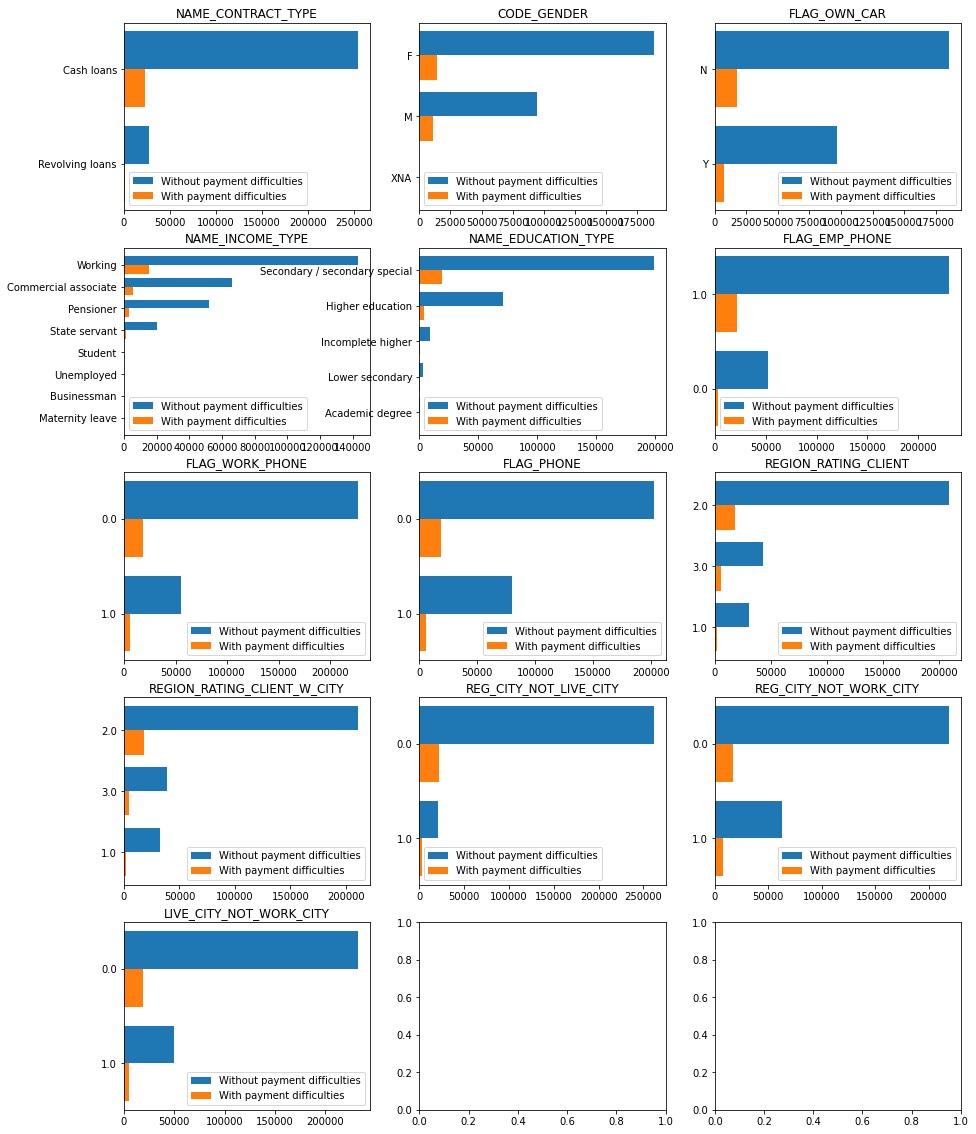

In [11]:
# Inverse data to it's original values
data_to_visualize = appl_train_top_20.copy()
for c in appl_train_top_20.columns:
    data_to_visualize[c] = min_max_scaler_dict[c].inverse_transform(appl_train_top_20[[c]])
for c in np.intersect1d(list(appl_train_top_20.columns), list(categorical_features)):
    data_to_visualize[c] = encoder_dict[c].inverse_transform(data_to_visualize[c].astype(int))

# Define the category list
col_to_visualize = appl_train_top_20.columns[1:]
categorical_features_complete = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
# note: I didnt include 'ORGANIZATION_TYPE' because there are so much categories

# For loop to plots
fig, ax = plt.subplots(5, 3, figsize=(15,20))
i = 0
for row in range(5):
    for col in range(3):
        if i > 19:
            break
        while col_to_visualize[i] not in categorical_features_complete and i < 19:
            i += 1
        if col_to_visualize[i] in categorical_features_complete:
            temp_pd = pd.concat([
                data_to_visualize[data_to_visualize['TARGET'] ==0][col_to_visualize[i]].value_counts(),
                data_to_visualize[data_to_visualize['TARGET'] ==1][col_to_visualize[i]].value_counts()],
                axis=1,).fillna(0)
            temp_pd.columns = ['Without payment difficulties', 'With payment difficulties']
            X_axis = np.arange(len(temp_pd.index))
            ax[row][col].barh(X_axis - 0.2, temp_pd['Without payment difficulties'], 0.4, label = 'Without payment difficulties')
            ax[row][col].barh(X_axis + 0.2, temp_pd['With payment difficulties'], 0.4, label = 'With payment difficulties')
            ax[row][col].set_yticks(X_axis, temp_pd.index, ha='right')
            ax[row][col].invert_yaxis()
            ax[row][col].legend()
            ax[row][col].set_title(col_to_visualize[i])
        i += 1


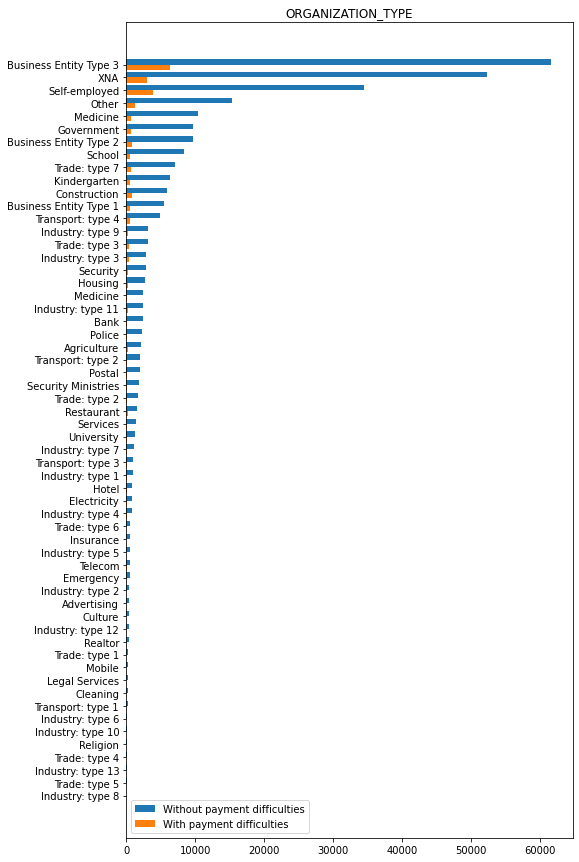

In [12]:
# PLot the Organization type
org_type_df = pd.concat([
    appl_train_top_20[appl_train_top_20['TARGET'] ==0]['ORGANIZATION_TYPE'].value_counts(),
    appl_train_top_20[appl_train_top_20['TARGET'] ==1]['ORGANIZATION_TYPE'].value_counts()],
    axis=1,
    ).fillna(0)
org_type_df.columns = ['Without payment difficulties', 'With payment difficulties']
org_type_df.index = encoder_dict['ORGANIZATION_TYPE'].inverse_transform(
    min_max_scaler_dict['ORGANIZATION_TYPE'].inverse_transform([org_type_df.index]).squeeze().astype(int))

wo_pd = org_type_df['Without payment difficulties']
w_pd = org_type_df['With payment difficulties']
  
X_axis = np.arange(len(org_type_df.index))

plt.figure(figsize=(8, 15))
plt.barh(X_axis - 0.2, wo_pd, 0.4, label = 'Without payment difficulties')
plt.barh(X_axis + 0.2, w_pd, 0.4, label = 'With payment difficulties')
plt.yticks(X_axis, org_type_df.index, ha='right')
plt.gca().invert_yaxis()
plt.title('ORGANIZATION_TYPE')
plt.legend()
plt.show()

### 3.1.2 Numerical Feature Distribution Plots

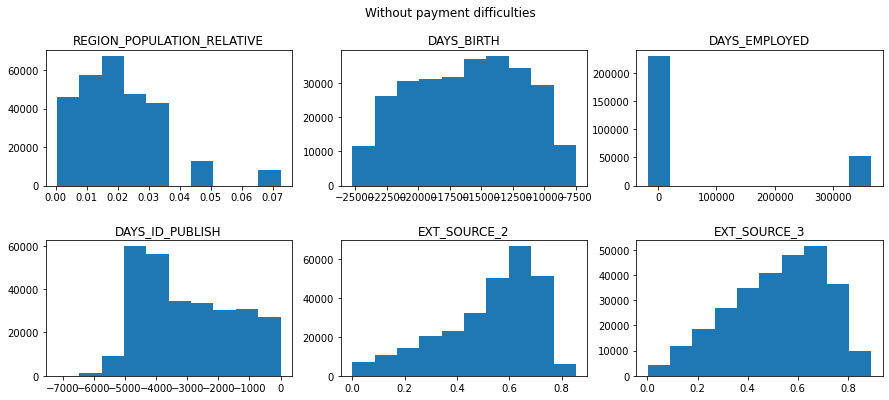

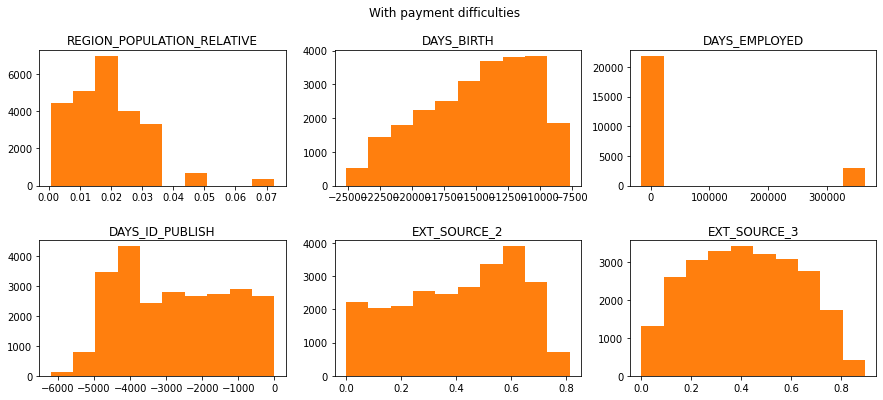

In [13]:
for idx, target in enumerate(['Without payment difficulties', 'With payment difficulties']):
    i = 0
    fig, ax = plt.subplots(2, 3, figsize=(15,6))
    plt.subplots_adjust(hspace=0.4)
    fig.suptitle(target)
    for row in range(2):
        for col in range(3):
            if i > 19:
                break
            while col_to_visualize[i] in categorical_features_complete+['ORGANIZATION_TYPE']:
                i += 1 
            if True:
                hist_1 = data_to_visualize[data_to_visualize['TARGET']==idx][col_to_visualize[i]]
                color = 'tab:orange' if idx==1 else 'tab:blue'
                ax[row][col].hist(data_to_visualize[data_to_visualize['TARGET']==idx][col_to_visualize[i]], color=color)
                ax[row][col].set_title(col_to_visualize[i])
            i += 1

### 3.1.3 Additional Graphs for Visualization Purpose

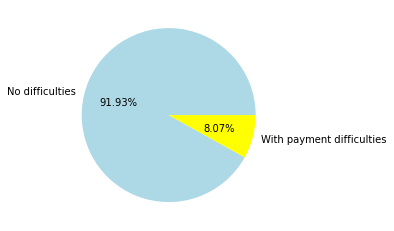

In [224]:
zzz = data_to_visualize[['TARGET', 'DAYS_BIRTH']].groupby('TARGET').count()
plt.figure(figsize=(6, 4))
plt.pie(zzz.values.ravel() / sum(zzz.values.ravel()), autopct="%1.2f%%", colors=['lightblue', 'yellow'], labels=['No difficulties', 'With payment difficulties'])
plt.show()

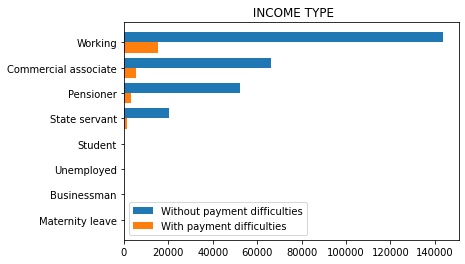

,Without payment difficulties,With payment difficulties
Working,143550,15224
Commercial associate,66257,5360
Pensioner,52380,2982
State servant,20454,1249
Student,18,0
Unemployed,14,8
Businessman,10,0
Maternity leave,3,2


In [227]:
plt.figure(figsize=(6,4))
temp_pd_zz = pd.concat([
    data_to_visualize[data_to_visualize['TARGET'] ==0]['NAME_INCOME_TYPE'].value_counts(),
    data_to_visualize[data_to_visualize['TARGET'] ==1]['NAME_INCOME_TYPE'].value_counts()],
    axis=1,).fillna(0).astype(int)
temp_pd_zz.columns = ['Without payment difficulties', 'With payment difficulties']
X_axis_zz = np.arange(len(temp_pd_zz.index))
plt.barh(X_axis_zz - 0.2, temp_pd_zz['Without payment difficulties'], 0.4, label = 'Without payment difficulties')
plt.barh(X_axis_zz + 0.2, temp_pd_zz['With payment difficulties'], 0.4, label = 'With payment difficulties')
plt.yticks(X_axis_zz, temp_pd_zz.index, ha='right')
plt.gca().invert_yaxis()
plt.legend()
plt.title(' INCOME TYPE')
plt.show()
temp_pd_zz

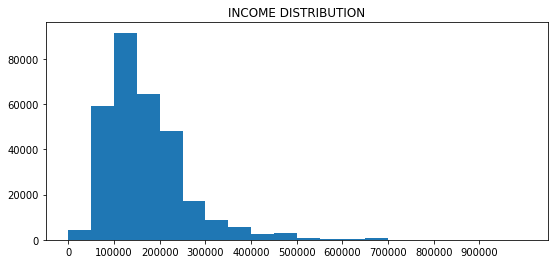

99.9 Percentile: 900000.0


,0,1
0,4517,0
1,59181,50000
2,91591,100000
3,64307,150000
4,48137,200000
5,17039,250000
6,8874,300000
7,5802,350000
8,2489,400000
9,2872,450000


In [286]:
plt.figure(figsize=(9, 4))

zzz = appl_train[['AMT_INCOME_TOTAL']][appl_train['AMT_INCOME_TOTAL']<np.percentile(appl_train['AMT_INCOME_TOTAL'], 99.9)]
plt.hist(appl_train[['AMT_INCOME_TOTAL']][appl_train['AMT_INCOME_TOTAL']<np.percentile(appl_train['AMT_INCOME_TOTAL'], 99.9)], range=(0, 1000000), bins=20)
X_axis_zz = np.arange(0, 1000000, 100000)
plt.xticks(X_axis_zz)
plt.ticklabel_format(style='plain')
plt.title("INCOME DISTRIBUTION")
plt.show()
appl_train[['AMT_INCOME_TOTAL', 'SK_ID_CURR']].set_index('SK_ID_CURR').sort_values('AMT_INCOME_TOTAL', ascending=False).head(10)
print(f"99.9 Percentile: {np.percentile(appl_train['AMT_INCOME_TOTAL'], 99.9)}")
pd.DataFrame(np.histogram(appl_train[['AMT_INCOME_TOTAL']][appl_train['AMT_INCOME_TOTAL']<np.percentile(appl_train['AMT_INCOME_TOTAL'], 99.9)], range=(0, 1000000), bins=20)).transpose().fillna(0).astype(int)

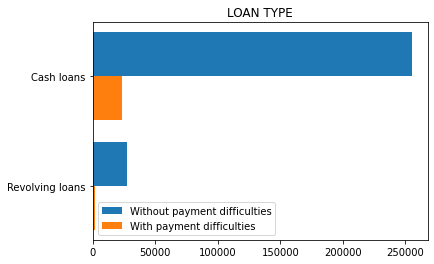

,Without payment difficulties,With payment difficulties
Cash loans,255011,23221
Revolving loans,27675,1604


In [311]:
plt.figure(figsize=(6,4))
temp_pd_zz = pd.concat([
    data_to_visualize[data_to_visualize['TARGET'] ==0]['NAME_CONTRACT_TYPE'].value_counts(),
    data_to_visualize[data_to_visualize['TARGET'] ==1]['NAME_CONTRACT_TYPE'].value_counts()],
    axis=1,).fillna(0).astype(int)
temp_pd_zz.columns = ['Without payment difficulties', 'With payment difficulties']
X_axis_zz = np.arange(len(temp_pd_zz.index))
plt.barh(X_axis_zz - 0.2, temp_pd_zz['Without payment difficulties'], 0.4, label = 'Without payment difficulties')
plt.barh(X_axis_zz + 0.2, temp_pd_zz['With payment difficulties'], 0.4, label = 'With payment difficulties')
plt.yticks(X_axis_zz, temp_pd_zz.index, ha='right')
plt.gca().invert_yaxis()
plt.legend()
plt.title('LOAN TYPE')
plt.show()
temp_pd_zz

## 3.2 Analysis and Insight

### 3.2.1 Customer Region With City Rating

From the categorical feature graphs above, there are one particular feature that interesting, it is REGION_RATING_CLIENT_W_CITY.
We can see that the the category 2 lead the customer base, followed far behind by category 3 and 1 with minor difference between those two.

Let's calculate the total percentage of each category:

In [14]:
# Total customer count
rrcwc = appl_train[['REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR']].groupby('REGION_RATING_CLIENT_W_CITY').count()
print("Customer count percentage:")
for i in rrcwc.index: print(f"{i}: {round(rrcwc.loc[i]/rrcwc.sum() * 100, 2).values[0]} %")
# Total loan sum
p = appl_train[['REGION_RATING_CLIENT_W_CITY', 'AMT_CREDIT']].groupby('REGION_RATING_CLIENT_W_CITY').sum()\
    .apply(lambda x: '%.5f' % x, axis=1).astype(float)
print("Total loan amount percentage:")
for i in p.index: print(f"{i}: {round(p.loc[i]/p.sum() * 100, 2)} %")

Customer count percentage:
1: 11.11 %
2: 74.63 %
3: 14.26 %
Total loan amount percentage:
1: 14.06 %
2: 72.47 %
3: 13.47 %


In [307]:
zzz1 = appl_train[['REGION_RATING_CLIENT_W_CITY','SK_ID_CURR']].groupby('REGION_RATING_CLIENT_W_CITY').count()
zzz2 = appl_train[['REGION_RATING_CLIENT_W_CITY','AMT_CREDIT']].groupby('REGION_RATING_CLIENT_W_CITY').sum()
zzz3 = pd.concat([zzz1, zzz2], axis=1)
zzz3['RATIO'] = zzz3['AMT_CREDIT'] / zzz3['SK_ID_CURR']
zzz3[['RATIO']]

,RATIO
REGION_RATING_CLIENT_W_CITY,
1,758160.943015
2,581714.265753
3,565638.000308


From the analysis above, we can see that while category 2 leads the total customer count, the loan per customer rate is led by category 1 more than category 2.

**I suggest that Home Credit Indonesia can expand their marketing in region with city rating category 1 so the company can achieve more total sum of customer loans with fewer customer count.**

Additional calculation:

### 3.2.2 Loan Types

Besides the RRCWC feature, there are one more feature that is interesting. From the contract type graph in the categorical graphs above, we can see that while the revolving loan have smaller customer base, it has small failed loan repayment count. Let's see the percentage as follow:

In [15]:
nct = appl_train[['TARGET', 'NAME_CONTRACT_TYPE', 'SK_ID_CURR']].groupby(['NAME_CONTRACT_TYPE', 'TARGET']).count()
print('without payment difficulty percentage:')
print(f"Cash loans: {round((nct.loc['Cash loans'].loc[0] / (nct.loc['Cash loans'].sum())) * 100, 2)[0]} %")
print(f"Revolving loans: {round((nct.loc['Revolving loans'].loc[0] / (nct.loc['Revolving loans'].sum())) * 100, 2)[0]} %")
# Total loan sum
nct2 = appl_train[['NAME_CONTRACT_TYPE', 'AMT_CREDIT']].groupby('NAME_CONTRACT_TYPE').sum()\
    .apply(lambda x: '%.5f' % x, axis=1).astype(float)
print("Total loan amount percentage:")
for i in nct2.index: print(f"{i}: {round(nct2.loc[i]/nct2.sum() * 100, 2)} %")

without payment difficulty percentage:
Cash loans: 91.65 %
Revolving loans: 94.52 %
Total loan amount percentage:
Cash loans: 94.85 %
Revolving loans: 5.15 %


From the analysis above, we can say that revolving loans have very high probability to successfully paid by customer with the success rate of 94.52%, that's very close to 95%. Even so, we can see that revolving loan share a much smaller total loan amount. It's 5.15% compared to 94.85% of by cash loans. There are huge gaps between the two.

**I suggest that Home Credit Indonesia can market the revolving loans more intensively so the we can increase the total amount share of revolving loans and close the gaps between the two. We also have a chance to decrease our customer's failure of repayment**

# 4. Machine Learning Implementation and Evaluation

## 4.1 Preparation

We'll use this code to ignore warnings from sklearn

In [16]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Here, we're importing the needed module/libraries and the dataset.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

# Load data
tr_features = appl_train_top_10.drop('TARGET', axis=1).copy().astype(float)
tr_labels = appl_train_top_10[['TARGET']].copy().astype(float)

Since we have very imbalance dataset, we can either upsampling the minority class or downsampling the majority class. Considering the limited compute power, we'll downsampling the majority class (TARGET=0) to match the amount of minority class data. We'll do the downsampling using RandomUnderSampler from sklearn. 

In [23]:
rus = RandomUnderSampler(random_state=20)
tr_features_resample, tr_labels_resample = rus.fit_resample(tr_features, tr_labels)
pd.concat([tr_features_resample, tr_labels_resample], axis=1).groupby('TARGET').count()

,NAME_CONTRACT_TYPE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,,,,,,,,,,
0.0,24825,24825,24825,24825,24825,24825,24825,24825,24825,24825
1.0,24825,24825,24825,24825,24825,24825,24825,24825,24825,24825


## 4.2 Training

For the training, we choose 5 classifier algorithms to test which one is the best by observing the f1 score and ROC AUC score. The 5 algorithms including:
- Logistic Regression
- Support Vector Machine
- Random Forest
- Gradient Boosting
- Multi Layer Perceptron

Below is the training and hyperparameter tuning using GridSearchCV for all the models.

In [24]:
def print_results(results: GridSearchCV):

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
    print('BEST PARAMS: {}\n'.format(results.best_params_))

### 4.2.1 Logistic Regression

In [31]:
lr = LogisticRegression()
lr_params = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100, 1000]
}
lr_cv = GridSearchCV(lr, lr_params, cv=3, verbose=3)
lr_cv.fit(tr_features_resample, tr_labels_resample.values)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...........................C=0.001;, score=0.649 total time=   0.0s
[CV 2/3] END ...........................C=0.001;, score=0.648 total time=   0.0s
[CV 3/3] END ...........................C=0.001;, score=0.656 total time=   0.0s
[CV 1/3] END ...........................C=0.005;, score=0.657 total time=   0.0s
[CV 2/3] END ...........................C=0.005;, score=0.654 total time=   0.0s
[CV 3/3] END ...........................C=0.005;, score=0.660 total time=   0.0s
[CV 1/3] END ............................C=0.01;, score=0.657 total time=   0.0s
[CV 2/3] END ............................C=0.01;, score=0.655 total time=   0.0s
[CV 3/3] END ............................C=0.01;, score=0.660 total time=   0.0s
[CV 1/3] END ............................C=0.05;, score=0.658 total time=   0.0s
[CV 2/3] END ............................C=0.05;, score=0.653 total time=   0.0s
[CV 3/3] END ............................C=0.05;,

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100,
                               1000]},
             verbose=3)

In [32]:
print_results(lr_cv)

0.651 (+/-0.007) for {'C': 0.001}
0.657 (+/-0.005) for {'C': 0.005}
0.657 (+/-0.004) for {'C': 0.01}
0.657 (+/-0.006) for {'C': 0.05}
0.658 (+/-0.005) for {'C': 0.1}
0.657 (+/-0.006) for {'C': 1}
0.657 (+/-0.006) for {'C': 10}
0.657 (+/-0.006) for {'C': 100}
0.657 (+/-0.006) for {'C': 1000}
BEST PARAMS: {'C': 0.1}



### 4.2.2 Support Vector Machine

In [38]:
svc = SVC()
svc_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}
svc_cv = GridSearchCV(svc, svc_params, cv=3, verbose=3)
svc_cv.fit(tr_features_resample, tr_labels_resample.values)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..............C=0.1, kernel=linear;, score=0.657 total time=  41.5s
[CV 2/3] END ..............C=0.1, kernel=linear;, score=0.653 total time=  44.2s
[CV 3/3] END ..............C=0.1, kernel=linear;, score=0.660 total time=  44.2s
[CV 1/3] END .................C=0.1, kernel=rbf;, score=0.659 total time= 1.6min
[CV 2/3] END .................C=0.1, kernel=rbf;, score=0.654 total time= 1.7min
[CV 3/3] END .................C=0.1, kernel=rbf;, score=0.657 total time= 1.7min
[CV 1/3] END ................C=1, kernel=linear;, score=0.657 total time=  45.7s
[CV 2/3] END ................C=1, kernel=linear;, score=0.653 total time=  45.8s
[CV 3/3] END ................C=1, kernel=linear;, score=0.659 total time=  46.6s
[CV 1/3] END ...................C=1, kernel=rbf;, score=0.660 total time= 1.6min
[CV 2/3] END ...................C=1, kernel=rbf;, score=0.656 total time= 1.6min
[CV 3/3] END ...................C=1, kernel=rbf;,

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             verbose=3)

In [39]:
print_results(svc_cv)

0.657 (+/-0.005) for {'C': 0.1, 'kernel': 'linear'}
0.657 (+/-0.004) for {'C': 0.1, 'kernel': 'rbf'}
0.657 (+/-0.005) for {'C': 1, 'kernel': 'linear'}
0.657 (+/-0.004) for {'C': 1, 'kernel': 'rbf'}
0.657 (+/-0.005) for {'C': 10, 'kernel': 'linear'}
0.658 (+/-0.004) for {'C': 10, 'kernel': 'rbf'}
BEST PARAMS: {'C': 10, 'kernel': 'rbf'}



### 4.2.3 Random Forest

In [33]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [5, 20, 250],
    'max_depth': [2, 4, 8, 16, 32]
}
rf_cv = GridSearchCV(rf, rf_params, cv=3, verbose=3)
rf_cv.fit(tr_features_resample, tr_labels_resample.values.ravel())

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END .......max_depth=2, n_estimators=5;, score=0.619 total time=   0.0s
[CV 2/3] END .......max_depth=2, n_estimators=5;, score=0.619 total time=   0.0s
[CV 3/3] END .......max_depth=2, n_estimators=5;, score=0.618 total time=   0.0s
[CV 1/3] END ......max_depth=2, n_estimators=20;, score=0.634 total time=   0.1s
[CV 2/3] END ......max_depth=2, n_estimators=20;, score=0.652 total time=   0.1s
[CV 3/3] END ......max_depth=2, n_estimators=20;, score=0.644 total time=   0.1s
[CV 1/3] END .....max_depth=2, n_estimators=250;, score=0.653 total time=   2.6s
[CV 2/3] END .....max_depth=2, n_estimators=250;, score=0.650 total time=   3.1s
[CV 3/3] END .....max_depth=2, n_estimators=250;, score=0.651 total time=   2.6s
[CV 1/3] END .......max_depth=4, n_estimators=5;, score=0.651 total time=   0.0s
[CV 2/3] END .......max_depth=4, n_estimators=5;, score=0.649 total time=   0.0s
[CV 3/3] END .......max_depth=4, n_estimators=5;

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32],
                         'n_estimators': [5, 20, 250]},
             verbose=3)

In [34]:
print_results(rf_cv)

0.619 (+/-0.0) for {'max_depth': 2, 'n_estimators': 5}
0.644 (+/-0.015) for {'max_depth': 2, 'n_estimators': 20}
0.651 (+/-0.002) for {'max_depth': 2, 'n_estimators': 250}
0.647 (+/-0.007) for {'max_depth': 4, 'n_estimators': 5}
0.655 (+/-0.002) for {'max_depth': 4, 'n_estimators': 20}
0.657 (+/-0.003) for {'max_depth': 4, 'n_estimators': 250}
0.654 (+/-0.008) for {'max_depth': 8, 'n_estimators': 5}
0.66 (+/-0.004) for {'max_depth': 8, 'n_estimators': 20}
0.662 (+/-0.005) for {'max_depth': 8, 'n_estimators': 250}
0.626 (+/-0.002) for {'max_depth': 16, 'n_estimators': 5}
0.645 (+/-0.002) for {'max_depth': 16, 'n_estimators': 20}
0.655 (+/-0.003) for {'max_depth': 16, 'n_estimators': 250}
0.601 (+/-0.003) for {'max_depth': 32, 'n_estimators': 5}
0.628 (+/-0.006) for {'max_depth': 32, 'n_estimators': 20}
0.642 (+/-0.003) for {'max_depth': 32, 'n_estimators': 250}
BEST PARAMS: {'max_depth': 8, 'n_estimators': 250}



### 4.2.4 Gradient Boosting

In [36]:
gb = GradientBoostingClassifier()
gb_params = {
    'n_estimators': [5, 50, 100, 250],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10]
}

gb_cv = GridSearchCV(gb, gb_params, cv=3, verbose=3)
gb_cv.fit(tr_features_resample, tr_labels_resample.values)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=5;, score=0.638 total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=5;, score=0.646 total time=   0.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=5;, score=0.633 total time=   0.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.651 total time=   2.1s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.648 total time=   2.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.645 total time=   2.5s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.653 total time=   4.4s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.650 total time=   4.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.647 total time=   4.4s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=250;, score=0.660 total 

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [5, 50, 100, 250]},
             verbose=3)

In [37]:
print_results(gb_cv)

0.639 (+/-0.01) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.648 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.65 (+/-0.005) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.658 (+/-0.005) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.651 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.655 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.657 (+/-0.005) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.661 (+/-0.005) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.652 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 5}
0.657 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
0.659 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
0.662 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250}
0.645 (+/-0.002) for {'lear

### 4.2.5 Multi Layer Perceptron

In [42]:
mlp = MLPClassifier()
mlp_params = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

mlp_cv = GridSearchCV(mlp, mlp_params, cv=3, verbose=3)
mlp_cv.fit(tr_features_resample, tr_labels_resample.values)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=constant;, score=0.658 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=constant;, score=0.656 total time=   1.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=constant;, score=0.658 total time=   3.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=invscaling;, score=0.661 total time=   2.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=invscaling;, score=0.656 total time=   1.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=invscaling;, score=0.661 total time=   1.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=adaptive;, score=0.661 total time=   2.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=(10,), learning_rate=adaptive;, score=0.656 total time=   2.0s
[CV 3/3] END activation=relu, hidden_

GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(10,), (50,), (100,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             verbose=3)

In [43]:
print_results(mlp_cv)

0.657 (+/-0.002) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.659 (+/-0.004) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.659 (+/-0.004) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.658 (+/-0.003) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.658 (+/-0.004) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.658 (+/-0.006) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.657 (+/-0.006) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.658 (+/-0.004) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.658 (+/-0.003) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}
0.658 (+/-0.004) for {'activation': 'tanh', 'hidden_layer_sizes': (10,), 

In case we need the model right away, save all the models for later use using joblib.

In [49]:
import joblib

models = {
    'LR': lr_cv.best_estimator_,
    'SVM': svc_cv.best_estimator_,
    'RF': rf_cv.best_estimator_,
    'GB': gb_cv.best_estimator_,
    'MLP': mlp_cv.best_estimator_
    }
for model in models:
    joblib.dump(models[model], f"./models/{model}.pkl")

## 4.3 Model Evaluation

### 4.3.1 Early Elimination

Next, we will compare the 5 models with its best parameters and evaluate each of them using the overall training set and use the f1 score and roc auc score to pick the best model.

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def eval_model(name, model, features, labels):
    pred = model.predict(features)
    acc = accuracy_score(labels, pred)
    prec = precision_score(labels, pred)
    rec = recall_score(labels, pred)
    f_1 = f1_score(labels, pred)
    roc_auc = roc_auc_score(labels, pred)
    print(f"{name}:\n     accuracy: {acc:.4f} | precision: {prec:.4f}\n     recall: {rec:.4f} | f_1: {f_1:.4f}\n     roc_auc: {roc_auc:.4f}")

for model in models:
    eval_model(model, models[model], tr_features_resample, tr_labels_resample)

LR:
     accuracy: 0.6570 | precision: 0.6620
     recall: 0.6415 | f_1: 0.6516
     roc_auc: 0.6570
SVM:
     accuracy: 0.6636 | precision: 0.6658
     recall: 0.6572 | f_1: 0.6615
     roc_auc: 0.6636
RF:
     accuracy: 0.6790 | precision: 0.6793
     recall: 0.6782 | f_1: 0.6787
     roc_auc: 0.6790
GB:
     accuracy: 0.6687 | precision: 0.6692
     recall: 0.6675 | f_1: 0.6683
     roc_auc: 0.6687
MLP:
     accuracy: 0.6592 | precision: 0.6670
     recall: 0.6359 | f_1: 0.6511
     roc_auc: 0.6592


From the metric scores observation above (F1 and ROC AUC score), we can clearly see that **Random Forest (RF)** model have the both largest F1 score and largest ROC AUC score. Since we want to see how it'll perform compared by **Logistic Regression (LR)**, we'll choose these 2 models to do K-Fold Cross-Validation testing.

### 4.3.2 K-Fold Cross-Validation

In [77]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10, shuffle=True, random_state=20)

In [88]:
new_rf = RandomForestClassifier(n_estimators=250, max_depth=8) # From the best previous hyperparameter
new_rf_f1 = cross_val_score(new_rf, tr_features_resample, tr_labels_resample.values.ravel(), cv=kfold, n_jobs=-1, scoring='f1')
new_rf_roc_auc = cross_val_score(new_rf, tr_features_resample, tr_labels_resample.values.ravel(), cv=kfold, n_jobs=-1, scoring='roc_auc')

new_lr = LogisticRegression(C=0.1) # From the best previous hyperparameter
new_lr_f1 = cross_val_score(new_lr, tr_features_resample, tr_labels_resample.values.ravel(), cv=kfold, n_jobs=-1, scoring='f1')
new_lr_roc_auc = cross_val_score(new_lr, tr_features_resample, tr_labels_resample.values.ravel(), cv=kfold, n_jobs=-1, scoring='roc_auc')

In [98]:
print(f"Random Forest:\n    \
F1: {np.mean(new_rf_f1):.3f} +/- {np.std(new_rf_f1):.3f} | ROC_AUC: {np.mean(new_rf_roc_auc):.3f} +/- {np.std(new_rf_roc_auc):.3f}\n\
Logistic Regression:\n    \
F1: {np.mean(new_lr_f1):.3f} +/- {np.std(new_lr_f1):.3f} | ROC_AUC: {np.mean(new_lr_roc_auc):.3f} +/- {np.std(new_lr_roc_auc):.3f}")

Random Forest:
    F1: 0.660 +/- 0.008 | ROC_AUC: 0.719 +/- 0.009
Logistic Regression:
    F1: 0.652 +/- 0.008 | ROC_AUC: 0.713 +/- 0.010


From the K-Fold Cross-Validation testing above, we can see that RF model have higher both F1 score and ROC_AUC score while maintain roughly the same deviation as the LR model. Thus, we will chose **Random Forest** model for the test data prediction.

But before we go to the prediction step, we will tune the hyperparameter once more but only for the RF model.

### 4.3.3 Final Model Tuning

In [103]:
final_rf = RandomForestClassifier()
final_rf_params = {
    'n_estimators': [200, 225, 250, 275, 300],
    'max_depth': [6, 7, 8, 9, 10]
}
final_rf_cv = GridSearchCV(rf, rf_params, cv=5, verbose=3, n_jobs=-1, scoring=['f1', 'roc_auc'], refit='roc_auc')
final_rf_cv.fit(tr_features_resample, tr_labels_resample.values.ravel())

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 16, 32],
                         'n_estimators': [5, 20, 250]},
             refit='roc_auc', scoring=['f1', 'roc_auc'], verbose=3)

In [108]:
print(final_rf_cv.best_params_)
print(f"{final_rf_cv.best_score_:.3f}")
joblib.dump(final_rf_cv.best_estimator_, './models/final_RF.pkl')

{'max_depth': 8, 'n_estimators': 250}
0.719


['./models/final_RF.pkl']

From the tuning above, we can see that the best parameter for the final RF model is still 8 max depth and 250 estimators. We will use it for the prediction.

# 5. Business Recommendation

Here, we will use the final model to do the TARGET prediction from test dataset.

In [154]:
# Load the test dataset
test_data = pd.read_csv('./home-credit-default-risk/application_test.csv')
test_features = test_data[tr_features_resample.columns].copy()

# Encode the categorical columns
for feature in encoder_dict.keys():
    try:
        test_features[feature] = encoder_dict[feature].transform(test_features[feature])
    except:
        continue

# Scale using MinMaxscaler
for feature in test_features.columns:
    test_features[feature] = min_max_scaler_dict[feature].transform(test_features[[feature]])
test_features['EXT_SOURCE_2'] = test_features['EXT_SOURCE_2'].apply(lambda x: x if str(x)!="nan" else np.random.choice(test_features[feature].dropna().values))
test_features['EXT_SOURCE_3'] = test_features['EXT_SOURCE_3'].apply(lambda x: x if str(x)!="nan" else np.random.choice(test_features[feature].dropna().values))

# Get prediction
test_result = final_rf_cv.best_estimator_.predict(test_features)
test_result = pd.concat([test_data['SK_ID_CURR'], pd.DataFrame(test_result)], axis=1)
test_result.columns = ['SK_ID_CURR', 'TARGET']
test_result.to_csv('test_result.csv', index=False)

We have get the prediction for the test dataset. Our model predict that 37.9% of our applicant will have payment difficulties and 62.1% won't have payment dificulties. We can say that while our model will help to predit the applicant payment difficulties, but **I suggest that don't use the model as an absolute decision maker. Instead, use the model as an early warning. anyone predicted will have payment difficulties should be inspected more carefully before we reject the application so we will not lose too much customer**.

Another business recommendation is as I mention before:
- **TI suggest that Home Credit Indonesia can expand their marketing in region with city rating category 1 so the company can achieve more total sum of customer loans with fewer customer count.**
- **The company should market the revolving loans more intensively so the we can increase the total amount share of revolving loans and close the gap between revolving and cash loan. We also have a chance to decrease our customer's failure of repayment**